# Deblur Photos with DeblurGAN-v2 and OpenVINO™

This tutorial demonstrates Single Image Motion Deblurring with DeblurGAN-v2 in OpenVINO, by first converting the [VITA-Group/DeblurGANv2](https://github.com/VITA-Group/DeblurGANv2) model to OpenVINO Intermediate Representation (OpenVINO IR) format. For more information about the model, see the [documentation](https://docs.openvino.ai/latest/omz_models_model_deblurgan_v2.html).

### What is deblurring?

Deblurring is the task of removing motion blurs that usually occur in photos shot with hand-held cameras when there are moving objects in the scene. Blurs not only reduce the human perception about the quality of the image, but also complicate computer vision analyses.

For more information, refer to the following research paper:

Kupyn, O., Martyniuk, T., Wu, J., & Wang, Z. (2019). [Deblurgan-v2: Deblurring (orders-of-magnitude) faster and better.](https://openaccess.thecvf.com/content_ICCV_2019/html/Kupyn_DeblurGAN-v2_Deblurring_Orders-of-Magnitude_Faster_and_Better_ICCV_2019_paper.html) In Proceedings of the IEEE/CVF International Conference on Computer Vision (pp. 8878-8887).

## Preparations

### Imports

In [1]:
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display
from openvino.runtime import Core

sys.path.append("../utils")
from notebook_utils import load_image

### Settings

In [2]:
# A device to use for inference. For example, "CPU", or "GPU".
DEVICE = "CPU"

# A directory where the model will be downloaded.
model_dir = Path("model")
model_dir.mkdir(exist_ok=True)

# The name of the model from Open Model Zoo.
model_name = "deblurgan-v2"
model_xml_path = model_dir / f"{model_name}.xml"
ov_model = None

precision = "FP16"

### Download DeblurGAN-v2 Model

Model defined in [VITA-Group/DeblurGANv2](https://github.com/VITA-Group/DeblurGANv2) repository. For converting model we should clone this repo and install its dependencies. To reduce conversion step, we will use OMZ downloader for downloading model weights. After downloading is finished, model related code will be saved in `model/public/deblurgan-v2/models/` directory and weights in `public/deblurgan-v2/ckpt/fpn_mobilenet.h5`

In [3]:
download_command = (
    f"omz_downloader --name {model_name} --output_dir"
    f" {model_dir} --cache_dir {model_dir}"
)
display(Markdown(f"Download command: `{download_command}`"))
display(Markdown(f"Downloading {model_name}..."))
! $download_command

Download command: `omz_downloader --name deblurgan-v2 --output_dir model --cache_dir model`

Downloading deblurgan-v2...

################|| Downloading deblurgan-v2 ||################

========== Retrieving model/public/deblurgan-v2/models/__init__.py from the cache

========== Retrieving model/public/deblurgan-v2/models/fpn_mobilenet.py from the cache

========== Retrieving model/public/deblurgan-v2/models/mobilenet_v2.py from the cache

========== Retrieving model/public/deblurgan-v2/models/networks.py from the cache

========== Retrieving model/public/deblurgan-v2/ckpt/fpn_mobilenet.h5 from the cache

========== Replacing text in model/public/deblurgan-v2/models/networks.py
========== Replacing text in model/public/deblurgan-v2/models/fpn_mobilenet.py
========== Replacing text in model/public/deblurgan-v2/models/fpn_mobilenet.py



### Prepare model

DeblurGAN-v2 is PyTorch model for converting it to OpenVINO Intermediate Representation format, we should first instantiate model class and load checkpoint weights. 

In [4]:
sys.path.append("model/public/deblurgan-v2")

import torch

from models.networks import get_generator


class DeblurV2(torch.nn.Module):
    def __init__(self, weights, model_name):
        super().__init__()

        parameters = {'g_name': model_name, 'norm_layer': 'instance'}
        self.impl = get_generator(parameters)
        checkpoint = torch.load(weights, map_location='cpu')['model']
        self.impl.load_state_dict(checkpoint)
        self.impl.train(True)

    def forward(self, image):
        out = self.impl(image)
        # convert out to [0, 1] range
        out = (out + 1) / 2
        return out

/home/ea/work/ov_venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Convert DeblurGAN-v2 Model to OpenVINO IR format

For best results with OpenVINO, it is recommended to convert the model to OpenVINO IR format. OpenVINO supports PyTorch via ONNX conversion. We will use `torch.onnx.export` for exporting the ONNX model from PyTorch. We need to provide initialized model object and example of inputs for shape inference. More information about torch.onnx.export provided in PyTorch [documentation](https://pytorch.org/docs/stable/onnx.html).

Then, we will use Model Optimizer Python API functionality to convert the ONNX model. The `mo.convert_model` Python function returns an OpenVINO model ready to load on device and start making predictions. We can save it on disk for next usage with `openvino.runtime.serialize`. For more information about Model Optimizer Python API, see the [Model Optimizer Developer Guide](https://docs.openvino.ai/latest/openvino_docs_MO_DG_Python_API.html).

Model Conversion may take a while.

In [5]:
from openvino.tools import mo
from openvino.runtime import serialize

deblur_gan_model = DeblurV2("model/public/deblurgan-v2/ckpt/fpn_mobilenet.h5", "fpn_mobilenet")

with torch.no_grad():
    deblur_gan_model.eval()
    torch.onnx.export(deblur_gan_model, torch.zeros((1,3,736,1312)), model_xml_path.with_suffix('.onnx'))
    ov_model = mo.convert_model(model_xml_path.with_suffix('.onnx'), compress_to_fp16=(precision == "FP16"))
    serialize(ov_model, str(model_xml_path))

/home/ea/work/ov_venv/lib/python3.8/site-packages/torch/onnx/_internal/jit_utils.py:258: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at ../torch/csrc/jit/passes/onnx/shape_type_inference.cpp:1884.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/home/ea/work/ov_venv/lib/python3.8/site-packages/torch/onnx/utils.py:687: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at ../torch/csrc/jit/passes/onnx/shape_type_inference.cpp:1884.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/home/ea/work/ov_venv/lib/python3.8/site-packages/torch/onnx/utils.py:1178: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong 

## Load the Model

Load and compile the DeblurGAN-v2 model in the OpenVINO Runtime with `ie.read_model` and compile it for the specified device with `ie.compile_model`. Get input and output keys and the expected input shape for the model.

In [6]:
ie = Core()
model = ie.read_model(model=model_xml_path)
compiled_model = ie.compile_model(model=model, device_name=DEVICE)

In [7]:
model_input_layer = compiled_model.input(0)
model_output_layer = compiled_model.output(0)

In [8]:
model_input_layer

<ConstOutput: names[input.1] shape[1,3,736,1312] type: f32>

In [9]:
model_output_layer

<ConstOutput: names[780] shape[1,3,736,1312] type: f32>

## Deblur Image

### Load, resize and reshape input image

The input image is read by using the default `load_image` function from `notebooks.utils`. Then, resized to meet the network expected input sizes, and reshaped to `(N, C, H, W)`, where `N` is a number of images in the batch, `C` is a number of channels, `H` is the height, and `W` is the width.

In [10]:
# Image filename (local path or URL)
filename = "https://raw.githubusercontent.com/VITA-Group/DeblurGANv2/master/test_img/000027.png"

In [11]:
# Load the input image.
# Load image returns image in BGR format
image = load_image(filename)

# Convert the image to expected by model RGB format
if image.shape[2] == 4:
    image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# N,C,H,W = batch size, number of channels, height, width.
N, C, H, W = model_input_layer.shape

# Resize the image to meet network expected input sizes.
resized_image = cv2.resize(image, (W, H))

# Convert image to float32 precision anf normalize in [-1, 1] range
input_image = (resized_image.astype(np.float32) - 127.5) / 127.5

# Add batch dimension to input image tensor
input_image = np.expand_dims(input_image.transpose(2, 0, 1), 0) 

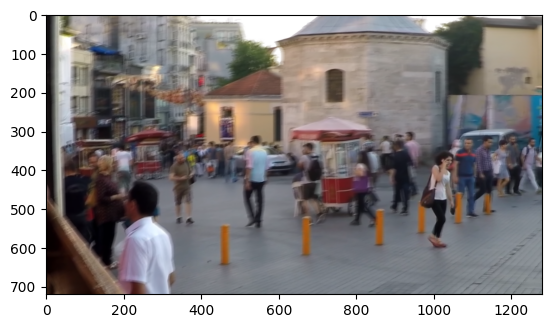

In [12]:
plt.imshow(image);

### Do Inference on the Input Image

Do the inference, convert the result to an image shape and resize it to the original image size.

In [13]:
# Inference.
result = compiled_model([input_image])[model_output_layer]

# Convert the result to an image shape and [0, 255] range
result_image = result[0].transpose((1, 2, 0)) * 255

h, w = image.shape[:2]

# Resize to the original image size and convert to original u8 precision
resized_result_image = cv2.resize(result_image, (w, h)).astype(np.uint8)

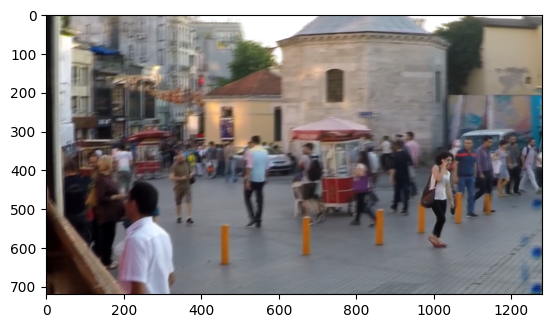

In [14]:
plt.imshow(resized_result_image);

### Display results

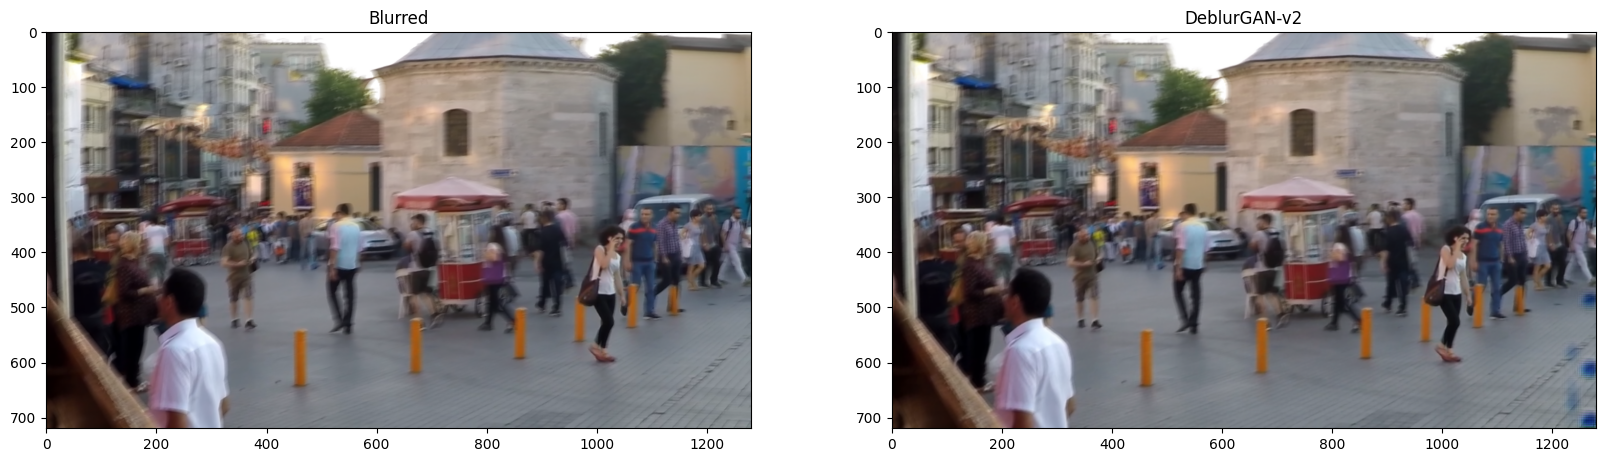

In [15]:
# Create subplot(r,c) by providing the no. of rows (r),
# number of columns (c) and figure size.
f, ax = plt.subplots(1, 2, figsize=(20, 20))

# Use the created array and display the images horizontally.
ax[0].set_title("Blurred")
ax[0].imshow(image)

ax[1].set_title("DeblurGAN-v2")
ax[1].imshow(resized_result_image);

### Save the deblurred image

Save the output image of the DeblurGAN-v2 model in the current directory.

In [16]:
savename = "deblurred.png"
cv2.imwrite(savename, resized_result_image);